In [1]:
import numpy as np
import pandas as pd
from datetime import date

import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
len(df)

48895

Price analysis

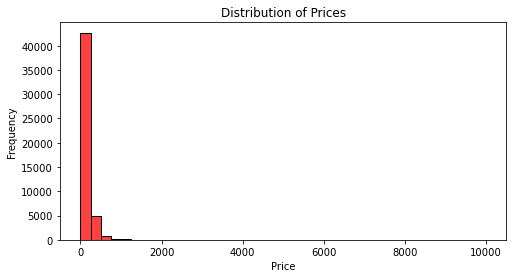

In [4]:
plt.figure(figsize=(8,4))

seaborn.histplot(df.price, bins=40, color="red")
plt.ylabel("Frequency")
plt.xlabel("Price")
plt.title("Distribution of Prices")

plt.show()

A long tail.

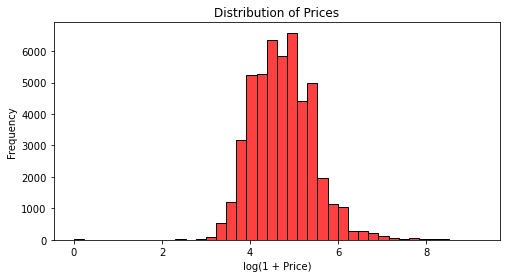

In [5]:
plt.figure(figsize=(8,4))

seaborn.histplot(np.log1p(df.price), bins=40, color="red")
plt.ylabel("Frequency")
plt.xlabel("log(1 + Price)")
plt.title("Distribution of Prices")

plt.show()

In [6]:
base = ['latitude', 'longitude', 'minimum_nights', 
        'number_of_reviews', 'reviews_per_month', 
        'calculated_host_listings_count', 'availability_365']

selected_cols = base + ['price']

df = df[selected_cols]
df.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
0,40.64749,-73.97237,1,9,0.21,6,365,149
1,40.75362,-73.98377,1,45,0.38,2,355,225
2,40.80902,-73.94190,3,0,NaN,1,365,150
3,40.68514,-73.95976,1,270,4.64,1,194,89
4,40.79851,-73.94399,10,9,0.10,1,0,80


# Question 1

In [7]:
df.isnull().sum()

latitude                              0
longitude                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
price                                 0
dtype: int64

In [8]:
len(df[df['number_of_reviews']==0])

10052

Wherever the number of reviews is 0, the feature reviews per month becomes NaN.

# Question 2

In [9]:
df.minimum_nights.median()

3.0

# Question 3

In [10]:
np.random.seed(42)
print(np.random.get_state()[1][0])

42


In [11]:
n = len(df)

#Split in sets - 60-20-20
n_validation = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_validation + n_test)

idx = np.arange(n)
np.random.shuffle(idx)
idx

array([  879, 44383, 15394, ..., 38158,   860, 15795])

In [12]:
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_test = df_shuffled.iloc[n_train:n_train+n_test].copy()
df_validation = df_shuffled.iloc[n_train+n_test:].copy()

y_train_orig = df_train.price.values
y_validation_orig = df_validation.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_validation = np.log1p(df_validation.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_validation['price']
del df_test['price']

In [13]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [14]:
def prepare_X(df, base):
    df_num = df[base]
    X = df_num.values
    return X

In [15]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Using 0-fill for reviews per month

In [16]:
df_train_copy = df_train.copy()
df_validation_copy = df_validation.copy()

df_train_copy['reviews_per_month'] = df_train_copy['reviews_per_month'].fillna(0)
df_validation_copy['reviews_per_month'] = df_validation_copy['reviews_per_month'].fillna(0)

In [17]:
X_train = prepare_X(df_train_copy, base)
w_0, w = train_linear_regression_reg(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('RMSE train', round(rmse(y_train, y_pred), 2))

X_validation = prepare_X(df_validation_copy, base)
y_pred = w_0 + X_validation.dot(w)
print('RMSE validation', round(rmse(y_validation, y_pred), 2))

RMSE train 0.64
RMSE validation 0.65


### Using mean fill for reviews per month

In [18]:
df_train_copy = df_train.copy()
df_validation_copy = df_validation.copy()

mean_reviews_pm = df_train_copy['reviews_per_month'].mean()
mean_reviews_pm

1.3685492094777056

In [19]:
df_train_copy['reviews_per_month'] = df_train_copy['reviews_per_month'].fillna(mean_reviews_pm)
df_validation_copy['reviews_per_month'] = df_validation_copy['reviews_per_month'].fillna(mean_reviews_pm)

In [20]:
X_train = prepare_X(df_train_copy, base)
w_0, w = train_linear_regression_reg(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('RMSE train', round(rmse(y_train, y_pred), 2))

X_validation = prepare_X(df_validation_copy, base)
y_pred = w_0 + X_validation.dot(w)
print('RMSE validation', round(rmse(y_validation, y_pred), 2))

RMSE train 0.64
RMSE validation 0.65


# Question 4

In [21]:
df_train_copy = df_train.copy()
df_validation_copy = df_validation.copy()

df_train_copy['reviews_per_month'] = df_train_copy['reviews_per_month'].fillna(0)
df_validation_copy['reviews_per_month'] = df_validation_copy['reviews_per_month'].fillna(0)

In [22]:
X_train = prepare_X(df_train_copy, base)
X_validation = prepare_X(df_validation_copy, base)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    print("r =", r)
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    y_pred = w_0 + X_train.dot(w)
    print('RMSE train', round(rmse(y_train, y_pred), 2))

    y_pred = w_0 + X_validation.dot(w)
    print('RMSE validation', round(rmse(y_validation, y_pred), 2))
    print()

r = 0
RMSE train 0.64
RMSE validation 0.65

r = 1e-06
RMSE train 0.64
RMSE validation 0.65

r = 0.0001
RMSE train 0.64
RMSE validation 0.65

r = 0.001
RMSE train 0.64
RMSE validation 0.65

r = 0.01
RMSE train 0.65
RMSE validation 0.67

r = 0.1
RMSE train 0.68
RMSE validation 0.69

r = 1
RMSE train 0.68
RMSE validation 0.69

r = 5
RMSE train 0.68
RMSE validation 0.69

r = 10
RMSE train 0.68
RMSE validation 0.69



# Question 5

In [23]:
rmse_vals = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(s)
    print("Seed:", s)
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_test = df_shuffled.iloc[n_train:n_train+n_test].copy()
    df_validation = df_shuffled.iloc[n_train+n_test:].copy()

    y_train_orig = df_train.price.values
    y_validation_orig = df_validation.price.values
    y_test_orig = df_test.price.values

    y_train = np.log1p(df_train.price.values)
    y_validation = np.log1p(df_validation.price.values)
    y_test = np.log1p(df_test.price.values)

    del df_train['price']
    del df_validation['price']
    del df_test['price']

    df_train['reviews_per_month'] = df_train['reviews_per_month'].fillna(0)
    df_validation['reviews_per_month'] = df_validation['reviews_per_month'].fillna(0)

    X_train = prepare_X(df_train, base)
    w_0, w = train_linear_regression_reg(X_train, y_train)

    y_pred = w_0 + X_train.dot(w)
    print('RMSE train', round(rmse(y_train, y_pred), 2))

    X_validation = prepare_X(df_validation, base)
    y_pred = w_0 + X_validation.dot(w)
    print('RMSE validation', round(rmse(y_validation, y_pred), 2))
    rmse_vals.append(rmse(y_validation, y_pred))
    print()

Seed: 0
RMSE train 0.65
RMSE validation 0.63

Seed: 1
RMSE train 0.64
RMSE validation 0.65

Seed: 2
RMSE train 0.65
RMSE validation 0.64

Seed: 3
RMSE train 0.65
RMSE validation 0.64

Seed: 4
RMSE train 0.64
RMSE validation 0.66

Seed: 5
RMSE train 0.65
RMSE validation 0.64

Seed: 6
RMSE train 0.65
RMSE validation 0.65

Seed: 7
RMSE train 0.64
RMSE validation 0.66

Seed: 8
RMSE train 0.65
RMSE validation 0.64

Seed: 9
RMSE train 0.65
RMSE validation 0.65



In [24]:
round(np.std(rmse_vals), 3)

0.007

# Question 6

In [25]:
np.random.seed(9)
print("Seed:", np.random.get_state()[1][0])
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_test = df_shuffled.iloc[n_train:n_train+n_test].copy()

y_train_orig = df_train.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_test['price']

df_train['reviews_per_month'] = df_train['reviews_per_month'].fillna(0)
df_test['reviews_per_month'] = df_test['reviews_per_month'].fillna(0)

X_train = prepare_X(df_train, base)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

y_pred = w_0 + X_train.dot(w)
print('RMSE train', round(rmse(y_train, y_pred), 2))

X_test = prepare_X(df_test, base)
y_pred = w_0 + X_test.dot(w)
print('RMSE test', round(rmse(y_test, y_pred), 2))

Seed: 9
RMSE train 0.65
RMSE test 0.64
